# 特徴量作成と選択の自動化


In [60]:
% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error

## データの読み込み

In [61]:
data = pd.read_csv("dataset/kc_house_data.csv")

In [62]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## ターゲット変数と特徴量を指定

In [63]:
target_col = 'price'
exclude_cols = ['price', 'id', 'date']
feature_cols = [col for col in data.columns if col not in exclude_cols]

## 特徴量を割り算で作成

In [64]:
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(feature_cols)-1):
    for j in range(i+1, len(feature_cols)):
        first_col_name = feature_cols[i]
        second_col_name = feature_cols[j]
        r = spearmanr(data[first_col_name], data[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            data[new_colname] = data[first_col_name] / (data[second_col_name] + 0.01)
            new_added_col.append(new_colname)

In [65]:
feature_cols = feature_cols + new_added_col

## ランダムフォレストによる特徴量の絞り込み

In [66]:
y = np.array(data[target_col])
X = np.array(data[feature_cols])

In [67]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [68]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [69]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [70]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [71]:
ypred = rf.predict(X_test)

In [72]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 132836.14279


In [83]:
rf.feature_importances_.max()

0.5039518241715818

## 変数の重要度の確認

In [74]:
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

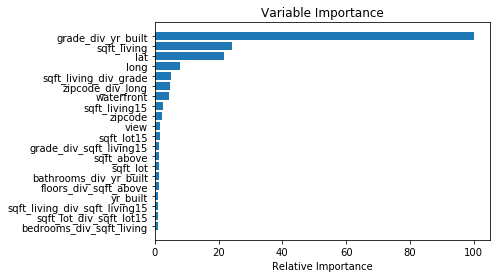

In [75]:
varImpPlot(rf, feature_cols, topN=20, verbose=False)

## 一定の重要度がなければ削除して再度モデル構築

In [76]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols)
new_feature_cols = feature_cols_ar[feature_importance > 0]

In [77]:
len(new_feature_cols)

39

In [78]:
len(feature_cols)

39

In [79]:
y = np.array(data[target_col])
X = np.array(data[new_feature_cols])

In [80]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [81]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

In [82]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 133825.050365
